<a href="https://colab.research.google.com/github/ragul-n/LendingClubPredicction/blob/master/Loan_Grading_without_Text_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install wordcloud

Downloading data from Kaggle:

* Upload your Kaggle API token (kaggle.json file) below to download data from kaggle.


In [ ]:
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!kaggle datasets download -d wordsforthewise/lending-club

Saving kaggle.json to kaggle.json
100% 1.26G/1.26G [00:08<00:00, 162MB/s]
100% 1.26G/1.26G [00:08<00:00, 166MB/s]


In [ ]:
!unzip lending-club.zip

Archive:  lending-club.zip
  inflating: accepted_2007_to_2018Q4.csv.gz  
  inflating: accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv  
  inflating: rejected_2007_to_2018Q4.csv.gz  
  inflating: rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv  


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display
import time

In [ ]:

#columns to be used
cols= ["loan_amnt" ,'term' ,'int_rate' , 'installment' ,'grade'  ,'emp_length' ,'home_ownership' ,'annual_inc' , 'dti' ,'verification_status' ,'issue_d' ,'loan_status' ,
            'pymnt_plan'  ,'zip_code' ,'addr_state' ,'dti' ,'fico_range_low' ,'fico_range_high' ,'tax_liens', "open_acc", "pub_rec",
        "revol_bal", "revol_util", "total_acc", "mort_acc", 'application_type']



In [ ]:
accepted_loans = pd.read_csv("/content/accepted_2007_to_2018Q4.csv.gz",  low_memory=False, usecols=cols)


In [ ]:
accepted_loans.drop(accepted_loans.tail(2).index, 
        inplace = True)

accepted_loans = accepted_loans[accepted_loans['application_type'] =="Individual"]

In [ ]:
accepted_loans= accepted_loans[[(not i) for i in accepted_loans['loan_amnt'].isna()]]

In [ ]:
accepted_loans["grade"].unique()

array(['C', 'F', 'B', 'A', 'E', 'D', 'G'], dtype=object)

In [ ]:
data = accepted_loans.drop([ "application_type" , "issue_d", "loan_status"], axis=1 )

In [ ]:
data=data.fillna({ "home_ownership":"not known", "emp_length": "not known", "zip_code": "000XX"})
data=data.fillna(data.mean(numeric_only=True))

# Data Analysis

In [ ]:
data.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,zip_code,addr_state,dti,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,tax_liens
0,3600.0,36 months,13.99,123.03,C,10+ years,MORTGAGE,55000.0,Not Verified,n,190xx,PA,5.91,675.0,679.0,7.0,0.0,2765.0,29.7,13.0,1.0,0.0
1,24700.0,36 months,11.99,820.28,C,10+ years,MORTGAGE,65000.0,Not Verified,n,577xx,SD,16.06,715.0,719.0,22.0,0.0,21470.0,19.2,38.0,4.0,0.0
3,35000.0,60 months,14.85,829.90,C,10+ years,MORTGAGE,110000.0,Source Verified,n,076xx,NJ,17.06,785.0,789.0,13.0,0.0,7802.0,11.6,17.0,1.0,0.0
4,10400.0,60 months,22.45,289.91,F,3 years,MORTGAGE,104433.0,Source Verified,n,174xx,PA,25.37,695.0,699.0,12.0,0.0,21929.0,64.5,35.0,6.0,0.0
5,11950.0,36 months,13.44,405.18,C,4 years,RENT,34000.0,Source Verified,n,300xx,GA,10.20,690.0,694.0,5.0,0.0,8822.0,68.4,6.0,0.0,0.0


Text(0.5, 1.0, 'Loan Grade Distribution')

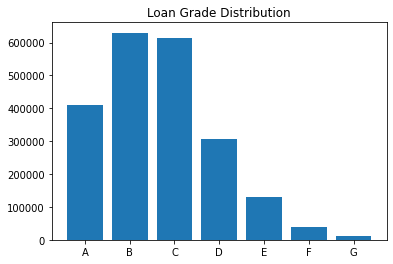

In [ ]:
val=dict(accepted_loans.groupby("grade")["grade"].count())

plt.bar( val.keys(),val.values(), width=0.8 )
plt.title("Loan Grade Distribution")

#preparing Data for training

In [ ]:
data.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,zip_code,addr_state,dti,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,tax_liens
0,3600.0,0,13.99,123.03,2,10+ years,MORTGAGE,55000.0,Not Verified,0,190xx,PA,5.91,675.0,679.0,7.0,0.0,2765.0,29.7,13.0,1.0,0.0
1,24700.0,0,11.99,820.28,2,10+ years,MORTGAGE,65000.0,Not Verified,0,577xx,SD,16.06,715.0,719.0,22.0,0.0,21470.0,19.2,38.0,4.0,0.0
3,35000.0,1,14.85,829.90,2,10+ years,MORTGAGE,110000.0,Source Verified,0,076xx,NJ,17.06,785.0,789.0,13.0,0.0,7802.0,11.6,17.0,1.0,0.0
4,10400.0,1,22.45,289.91,5,3 years,MORTGAGE,104433.0,Source Verified,0,174xx,PA,25.37,695.0,699.0,12.0,0.0,21929.0,64.5,35.0,6.0,0.0
5,11950.0,0,13.44,405.18,2,4 years,RENT,34000.0,Source Verified,0,300xx,GA,10.20,690.0,694.0,5.0,0.0,8822.0,68.4,6.0,0.0,0.0


In [ ]:
data.grade= pd.Categorical(data.grade)
data['grade']= data.grade.cat.codes

data.term= pd.Categorical(data.term)
data['term']= data.term.cat.codes

data.pymnt_plan= pd.Categorical(data.pymnt_plan)
data['pymnt_plan']= data.pymnt_plan.cat.codes

data.emp_length= pd.Categorical(data.emp_length)
data.emp_length= data.emp_length.cat.codes

data.home_ownership= pd.Categorical(data.home_ownership)
data.home_ownership= data.home_ownership.cat.codes

data.verification_status= pd.Categorical(data.verification_status)
data.verification_status= data.verification_status.cat.codes

data.zip_code = pd.Categorical(data.zip_code)
data.zip_code= data.zip_code.cat.codes

data.addr_state= pd.Categorical(data.addr_state)
data.addr_state= data.addr_state.cat.codes

In [ ]:
data.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,zip_code,addr_state,dti,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,tax_liens
0,3600.0,0,13.99,123.03,2,1,1,55000.0,0,0,183,38,5.91,675.0,679.0,7.0,0.0,2765.0,29.7,13.0,1.0,0.0
1,24700.0,0,11.99,820.28,2,1,1,65000.0,0,0,555,41,16.06,715.0,719.0,22.0,0.0,21470.0,19.2,38.0,4.0,0.0
3,35000.0,1,14.85,829.90,2,1,1,110000.0,1,0,70,31,17.06,785.0,789.0,13.0,0.0,7802.0,11.6,17.0,1.0,0.0
4,10400.0,1,22.45,289.91,5,3,1,104433.0,1,0,167,38,25.37,695.0,699.0,12.0,0.0,21929.0,64.5,35.0,6.0,0.0
5,11950.0,0,13.44,405.18,2,4,5,34000.0,1,0,291,10,10.20,690.0,694.0,5.0,0.0,8822.0,68.4,6.0,0.0,0.0


In [ ]:
y= data['grade']
x=data.drop('grade', axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test,y_train, y_test= train_test_split(x, y, test_size=0.2, random_state=1)

x_test, x_val,y_test, y_val= train_test_split(x_test, y_test, test_size=0.5, random_state=1)


In [ ]:
training_data= tf.data.Dataset.from_tensor_slices((x_train.values,  y_train.values))
validation_data= tf.data.Dataset.from_tensor_slices((x_val.values, y_val.values))
test_data= tf.data.Dataset.from_tensor_slices((x_test.values,  y_test.values))

In [ ]:
training_data= training_data.batch(256)
validation_data=validation_data.batch(513)
test_data= test_data.batch(512)

#Building Model

In [ ]:
model= tf.keras.Sequential([tf.keras.layers.Dense(64, activation="relu"),
                            tf.keras.layers.Dense(64, activation="relu"),
                            tf.keras.layers.Dense(64, activation="relu"),
                            tf.keras.layers.Dense(32, activation="relu"), 
                            tf.keras.layers.Dense(16, activation="relu"),
                            tf.keras.layers.Dense(7, activation="softmax"),
                            ])


#Training Model

In [ ]:
 with tf.device('/GPU:0'): 
    model= LoanGrader(3, 128, 4, 256)


In [ ]:
for x, sequence, y in training_data:
    model(x, sequence)
    break

model.summary()

Model: "loan_grader_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_9 (Encoder)          multiple                  11311616  
_________________________________________________________________
flatten_9 (Flatten)          multiple                  0         
_________________________________________________________________
concatenate_9 (Concatenate)  multiple                  0         
_________________________________________________________________
batch_normalization_9 (Batch multiple                  64        
_________________________________________________________________
dense_231 (Dense)            multiple                  526464    
_________________________________________________________________
dense_232 (Dense)            multiple                  8256      
_________________________________________________________________
dense_233 (Dense)            multiple               

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([ 0.74388348,  0.48534454,  0.49873275,  1.0001332 ,  2.36852292,
        7.65179186, 26.68775332])

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=3500):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) #CustomSchedule(128, warmup_steps=500)
#encoder_optimizer=  tf.keras.optimizers.Adam(learning_rate=CustomSchedule(64, warmup_steps=500))



model.compile(optimizer=optimizer)

In [ ]:

with tf.device('/GPU:0'): 
    model.train(training_data, 10, validation_data=validation_data, class_weights=[1,1,1,1,1,1,1]) 

Epoch  1  :


'     100% Compleated  | Loss 0.4443 | Accuracy 80.73% | Time: 13.0 mins'

'   Validation: 100% Compleated | Loss 0.3185 Accuracy | 86.26% | Time: 0.0 mins'

Epoch  2  :


'     100% Compleated  | Loss 0.3661 | Accuracy 83.81% | Time: 13.0 mins'

'   Validation: 100% Compleated | Loss 0.3120 Accuracy | 86.51% | Time: 0.0 mins'

Epoch  3  :


'     100% Compleated  | Loss 0.3552 | Accuracy 84.28% | Time: 13.0 mins'

'   Validation: 100% Compleated | Loss 0.3075 Accuracy | 86.42% | Time: 0.0 mins'

Epoch  4  :


'     100% Compleated  | Loss 0.3516 | Accuracy 84.45% | Time: 13.0 mins'

'   Validation: 100% Compleated | Loss 0.3072 Accuracy | 86.55% | Time: 0.0 mins'

Epoch  5  :


'     0% Compleated  | Loss 0.3621 | Accuracy 83.28% | Time: 0.0 mins'

In [ ]:
len([model.trainable_variables] + [model.trainable_variables] )